# E-commerce Product recommendation System

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

## Importing Dataset

Downloaded from [here](https://www.kaggle.com/datasets/vibivij/amazon-electronics-rating-datasetrecommendation/)

In [2]:
df = pd.read_csv('ratings_Electronics.csv', header=None)
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names since not available in dataset
df = df.drop('timestamp', axis=1)
df_copy = df.copy(deep=True)

In [3]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  7824482
No of columns =  3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [5]:
# Number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

In [6]:
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Rating distribution

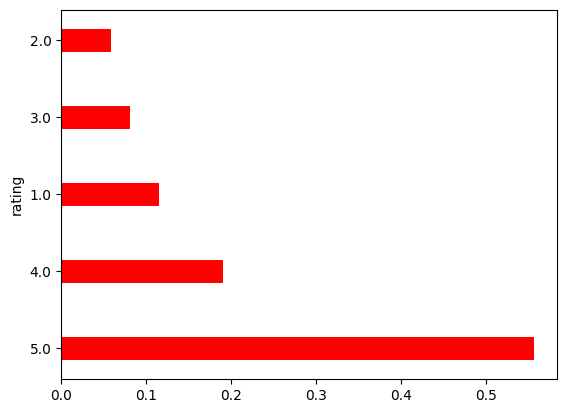

In [7]:
df['rating'].value_counts(1).plot(kind='barh', color='red', width=0.3)
plt.show()

In [8]:
print('Number of unique users in Raw data = ', df['user_id'].nunique())
print('Number of unique products in Raw data = ', df['prod_id'].nunique())

Number of unique users in Raw data =  4201696
Number of unique products in Raw data =  476002


In [9]:
# Top 10 users with most number of rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [10]:
# Only including users who have given 50 or more number of ratings to reduce sparsity
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [11]:
print('Number of rows in the final data =', len(df_final))
print('Number of unique users in the final data = ', df_final['user_id'].nunique())
print('Number of unique products in the final data = ', df_final['prod_id'].nunique())

Number of rows in the final data = 125871
Number of unique users in the final data =  1540
Number of unique products in the final data =  48190


### Checking the density of the rating matrix

In [12]:
# Matrix of products and users based on ratings
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating')
final_ratings_matrix = final_ratings_matrix.fillna(0) # Fill values
print('Shape of ratings matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('Number of Non-zero ratings = ', given_num_of_ratings)

possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Total possible ratings = ', possible_num_of_ratings)

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('Density: {:4.2f}%'.format(density))

# final_ratings_matrix.head()

Shape of ratings matrix:  (1540, 48190)
Number of Non-zero ratings =  125871
Total possible ratings =  74212600
Density: 0.17%


# Collaborative Filtering based Recommendation System 

**Recommnend products interacted with by similar users (determined using cosine similarity)**

In [13]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])  # Integer user indexes
final_ratings_matrix.set_index(['user_index'], inplace=True)

final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# To get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]):
        
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        similarity.append((user,sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity]
    similarity_score = [tup[1] for tup in similarity]
   
    # Remove original one
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

In [16]:
# Finding out top 10 similar users to the user index 3 and their similarity score
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [17]:
# Similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

In [18]:
# Finding out top 10 similar users to the user index 1298 and their similarity score
similar = similar_users(1298, final_ratings_matrix)[0][0:10]
similar

[312, 508, 1205, 435, 460, 469, 196, 1195, 188, 1055]

In [19]:
# Similarity score
similar_users(1298, final_ratings_matrix)[1][0:10]

[array([[0.06171554]]),
 array([[0.0402577]]),
 array([[0.0402577]]),
 array([[0.03942849]]),
 array([[0.03499808]]),
 array([[0.03490995]]),
 array([[0.0321596]]),
 array([[0.03161595]]),
 array([[0.03066209]]),
 array([[0.03002778]])]

In [20]:
# Get recommendations by using the similar user's preferences
def recommendations(user_index, num_of_products, interactions_matrix):
    
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    # Finding product IDs with which the user_id has interacted (used below)
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            # Finding n products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

In [21]:
# Recommend 5 producs to user index 3
recommendations(3, 5, final_ratings_matrix)

['B00007M1TZ', 'B00114LG7U', 'B0011WCVPI', 'B005FAPYXS', 'B000DZH4V0']

In [22]:
# Recommend 8 producs to user index 1298
recommendations(1298, 8, final_ratings_matrix)

['B0045JCFLY',
 'B000F0ELOG',
 'B005B5G4S6',
 'B00155RGYM',
 'B000VZS2EU',
 'B000BM8RFM',
 'B004EBUN2Q',
 'B002PJESBG']

# Model based Collaborative Filtering using Singular Value Decomposition (SVD)

**SVD is best to apply on a large sparse matrix. 
Using the sparse.linalg.svds() function to perform the decomposition**

In [23]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

In [24]:
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [25]:
U.shape

(1540, 50)

In [26]:
sigma.shape

(50, 50)

In [27]:
Vt.shape

(50, 48190)

In [28]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

In [29]:
def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    # Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    temp = temp.sort_values('user_predictions',ascending=False)
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


In [30]:
# Recommending top 5 products to user id 121
recommend_items(121, final_ratings_sparse, preds_matrix, 5)


Below are the recommended products for user(user_id = 121):

Recommended Products
28761    2.414390
39003    1.521306
41420    1.309224
40158    1.200111
33819    1.126866
Name: user_predictions, dtype: float64


In [31]:
# Recommending top 10 products to user id 100
recommend_items(100, final_ratings_sparse, preds_matrix, 10)


Below are the recommended products for user(user_id = 100):

Recommended Products
11078    1.624746
16159    1.132730
10276    1.047888
22210    0.955049
18887    0.879705
41618    0.854430
45008    0.816153
43419    0.803755
28761    0.748799
14791    0.748797
Name: user_predictions, dtype: float64


## Evaluating the model

In [32]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

prod_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [34]:
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


In [35]:
avg_preds=preds_df.mean()
avg_preds.head()

prod_id
0594451647    0.003360
0594481813    0.005729
0970407998    0.008566
0972683275    0.035330
1400501466    0.006966
dtype: float64

In [36]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)
rmse_df.columns = ['Avg actual ratings', 'Avg predicted ratings']

rmse_df.head()

,Avg actual ratings,Avg predicted ratings
prod_id,,
0594451647,0.003247,0.003360
0594481813,0.001948,0.005729
0970407998,0.003247,0.008566
0972683275,0.012338,0.035330
1400501466,0.012987,0.006966


In [37]:
RMSE=mean_squared_error(rmse_df['Avg actual ratings'], rmse_df['Avg predicted ratings'])
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.00018712570474928346 

